In [ ]:
#Only run to mount google drive
#from google.colab import drive
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
#####https://www.analyticsvidhya.com/blog/2024/10/langgraph-react-function-calling/
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG) #logging.INFO
logging.debug("test")
logging.info('test2')

DEBUG:root:test
INFO:root:test2


In [2]:
!pip install duckduckgo-search
!pip install langchain-community
!pip install langchain-experimental
!pip install langchain-openai
!pip install langchainhub
!pip install langgraph

In [ ]:
import os
from openai import OpenAI
#0. Setting the OpenAI API key from google colab
#from google.colab import userdata
#os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
#1. GET your OpenAI API key from the OpenAI dashboard
api_key = os.getenv("OPENAI_API_KEY")
#2. Create a new OpenAI instance
#client = OpenAI(api_key=api_key)
#3. Set the chat model
chat_model="gpt-4o-mini"

In [10]:
import os
from langchain_openai import ChatOpenAI


#Initializing the language model
llm = ChatOpenAI(api_key= api_key, 
                 model=chat_model)

In [11]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b

In [13]:
# search tools
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

In [14]:
tools = [add, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [15]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage


# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXJlYXNvbmVyKHJlYXNvbmVyKQoJdG9vbHModG9vbHMpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiByZWFzb25lcjsKCXRvb2xzIC0tPiByZWFzb25lcjsKCXJlYXNvbmVyIC0uLT4gdG9vbHM7CglyZWFzb25lciAtLi0+IF9fZW5kX187CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 9291


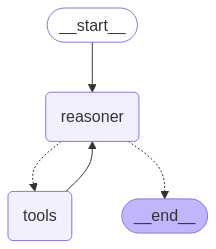

In [16]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})
#Displaying the response
for m in messages['messages']:
    m.pretty_print()

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.', 'role': 'system'}, {'content': "What is 2 times Brad Pitt's age?", 'role': 'user'}], 'model': 'gpt-4o-mini', 'stream': False, 'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.\nArgs:\n    a: firs

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_JNYjFG2Di6xN28BUKGBeS9Rr)
 Call ID: call_JNYjFG2Di6xN28BUKGBeS9Rr
  Args:
    query: Brad Pitt age
================================= Tool Message =================================
Name: duckduckgo_search

Brad Pitt is an American actor known for his portrayal of unconventional characters. He channeled his magnetism as a leading man in Legends of the Fall (1994) but avoided being typecast by playing offbeat characters. ... December 18, 1963, Shawnee, Oklahoma, U.S. (age 61) (Show more) Founder: Make It Right Not on Our Watch (Show more) Awards ... Brad Pitt Age. Brad Pitt age 61 years old in 2024, He was born on December 18, 1963 in Shawnee, Oklahoma in the United States. Brad Pitt Height and Weight . Brad Pitt is an educated, attractive, and dashing boy wi

In [27]:
##Adding a Custom Tool for Stock Prices
!pip install yfinance

In [28]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']
get_stock_price("AAPL")

DEBUG:yfinance:Using User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 14_7_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Safari/605.1.15
DEBUG:yfinance:get_raw_json(): https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAPL
DEBUG:yfinance:Entering get()
DEBUG:yfinance: Entering _make_request()
DEBUG:yfinance:url=https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAPL
DEBUG:yfinance:params={'modules': 'financialData,quoteType,defaultKeyStatistics,assetProfile,summaryDetail', 'corsDomain': 'finance.yahoo.com', 'formatted': 'false', 'symbol': 'AAPL'}
DEBUG:yfinance:  Entering _get_cookie_and_crumb()
DEBUG:yfinance:cookie_mode = 'basic'
DEBUG:yfinance:   Entering _get_cookie_and_crumb_basic()
DEBUG:peewee:('CREATE TABLE IF NOT EXISTS "_cookieschema" ("strategy" VARCHAR(255) NOT NULL PRIMARY KEY, "fetch_date" DATETIME NOT NULL, "cookie_bytes" BLOB NOT NULL) WITHOUT ROWID', [])
DEBUG:peewee:('SELECT "t1"."strategy", "t1"."fetch_date", "t1"."cookie_bytes" FROM "_coo

221.53

In [29]:
from langchain_core.messages import HumanMessage, SystemMessage
def reasoner1(state):
    query = state["query"]
    messages = state["messages"]
    # System message indicating the assistant's capabilities
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    # Invoke the LLM with the messages
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [31]:
# Update the tools list to include the stock price function
tools = [add, multiply, divide, search, get_stock_price]
# Re-initialize the language model with the updated tools
llm = ChatOpenAI(api_key=api_key,
                model=chat_model
                )
llm_with_tools = llm.bind_tools(tools)


tools[4]

<function __main__.get_stock_price(ticker: str) -> float>

In [32]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

In [33]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode
# Graph
workflow = StateGraph(GraphState)
# Add Nodes
workflow.add_node("reasoner", reasoner1)
workflow.add_node("tools", ToolNode(tools))

In [35]:
# Add Edges
workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

ValueError: Branch with name `tools_condition` already exists for node `reasoner`

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXJlYXNvbmVyKHJlYXNvbmVyKQoJdG9vbHModG9vbHMpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiByZWFzb25lcjsKCXRvb2xzIC0tPiByZWFzb25lcjsKCXJlYXNvbmVyIC0uLT4gdG9vbHM7CglyZWFzb25lciAtLi0+IF9fZW5kX187CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 9291


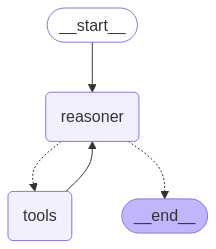

In [36]:
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [37]:
response = react_graph.invoke({"query": "What is 2 times Brad Pitt's age?", "messages": []})
response['messages'][-1].pretty_print()

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.', 'role': 'system'}, {'content': "What is 2 times Brad Pitt's age?", 'role': 'user'}], 'model': 'gpt-4o-mini', 'stream': False, 'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a an

DEBUG:httpcore.connection:connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x1698ae870>
DEBUG:httpcore.connection:start_tls.started ssl_context=<ssl.SSLContext object at 0x169366950> server_hostname='api.openai.com' timeout=None
DEBUG:httpcore.connection:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x1698af350>
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Fri, 28 Mar 2025 06:56:56 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-expose-headers', 

================================== Ai Message ==================================

2 times Brad Pitt's age (61) is 122.


In [20]:
response = react_graph.invoke({"query": "What is the stock price of Apple?", "messages": []})
for m in response['messages']:
    m.pretty_print()

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.', 'role': 'system'}, {'content': 'What is the stock price of Apple?', 'role': 'user'}], 'model': 'gpt-4o', 'stream': False, 'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})
for m in response['messages']:
    m.pretty_print()

In [ ]:
response = react_graph.invoke({"query": "What will be the price of nvidia stock if it doubles?", "messages": []})
for m in response['messages']:
    m.pretty_print()

In [ ]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})
for m in response['messages']:
    m.pretty_print()